In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

## 2. Analysis

Read in the csv

In [3]:
input_df = pd.read_csv("ec_data_sentiment_analysis.csv", index_col=0)
## add year-quarter column to serve as x-axis for time series
input_df["year-quarter"] = input_df['year'].astype(str) + "Q" + input_df['quarter'].astype(str) 
input_df['date'] = pd.to_datetime(input_df["year-quarter"])

input_df

,ticker,year,quarter,speaker-name,speaker-context,is-asker,remark-number,sentence-number,sentence,sentiment,score,year-quarter,date
0,TSLA,2022,4,rod-lache,wolfe-research,True,0,0,I think I'm unmuted.,neutral,0.789545,2022Q4,2022-10-01
1,TSLA,2022,4,rod-lache,wolfe-research,True,0,1,Can you hear me?,neutral,0.898343,2022Q4,2022-10-01
2,TSLA,2022,4,rod-lache,wolfe-research,True,0,2,"Martin Viecha\nYes, we can.",neutral,0.845495,2022Q4,2022-10-01
3,TSLA,2022,4,rod-lache,wolfe-research,True,1,0,OK.,neutral,0.858962,2022Q4,2022-10-01
4,TSLA,2022,4,rod-lache,wolfe-research,True,1,1,Thank you.,neutral,0.823482,2022Q4,2022-10-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
46420,LI,2020,3,kai-wang,chief-technology-officer,False,5,25,Thank you.,neutral,0.823482,2020Q3,2020-07-01
46421,LI,2020,3,kai-wang,chief-technology-officer,False,5,26,Unknown speaker\nThank you.,neutral,0.897747,2020Q3,2020-07-01
46422,LI,2020,3,kai-wang,chief-technology-officer,False,5,27,Operator\nThank you.,neutral,0.722440,2020Q3,2020-07-01
46423,LI,2020,3,kai-wang,chief-technology-officer,False,5,28,We have our next question from the line of Rob...,neutral,0.935518,2020Q3,2020-07-01


Sets positive to 1, negative to -1, and neutral to 0. Useful for scoring

In [4]:
def sentiment_rating(sentiment_label):
    """
    Returns -1 for negative, 0 for neutral, 1 for positive
    """
    return -1 if sentiment_label == "negative" else (0 if sentiment_label == "neutral" else 1)

In [5]:
input_df["sentiment-rating"] = input_df.apply(lambda x : sentiment_rating(x["sentiment"]), axis = 1)

We only care about the speakers, not the question askers

In [49]:
speaker_df = input_df[input_df["is-asker"] == False]
speaker_df[speaker_df["sentiment-rating"] == 0].sort_values(["score"], ascending=False).iloc[0]

ticker                                                             LI
year                                                             2021
quarter                                                             4
speaker-name                                            johnny-tie-li
speaker-context                               chief-financial-officer
is-asker                                                        False
remark-number                                                       1
sentence-number                                                     5
sentence            And we expect to be included in the connect in...
sentiment                                                     neutral
score                                                        0.956045
year-quarter                                                   2021Q4
date                                              2021-10-01 00:00:00
sentiment-rating                                                    0
Name: 44722, dtype: 

### Scoring sentiment

Sentiment should be scored via the following formula:

$$\text{sentiment} = \frac{\text{\# positively rated sentences} - \text{\# negatively rated sentences}}{\text{total \# of sentences}}$$

I can compute this by summing the sentiment-rating column and dividing by the max sentence number per remark. Summing the sentiment-rating column will give me the numerator because I am adding +1 for positive and adding -1 (same as subtracting by 1) for negative.

Function to calculate the score

In [7]:
def score(group):
    return pd.Series({"sentiment-score": group["sentiment-rating"].sum() / len(group["sentence-number"])})

This function takes in a DataFrame and then a list of arguments which is the columns to group by (in order left to right)

In [8]:
def group_and_score(df, args):
    return df.groupby(args).apply(score)

## Examples of applying the score function

Per remark individual remark

In [53]:
group_and_score(input_df, ["ticker", "date"])

sentiment-score
ticker date                       
F      2018-04-01         0.121008
       2018-07-01         0.196460
       2018-10-01         0.157895
       2019-01-01         0.223622
       2019-04-01         0.258517
...                            ...
TSLA   2021-07-01         0.137993
       2021-10-01         0.107547
       2022-04-01         0.101549
       2022-07-01         0.126712
       2022-10-01         0.135029

[96 rows x 1 columns]

Per speaker

In [55]:
group_and_score(speaker_df, ["ticker", "date","speaker-context"])

sentiment-score
ticker date       speaker-context                                                    
F      2018-04-01 executive-director-of-investor-relations                   0.000000
                  executive-vice-president-and-president-of-globa...         0.320988
                  president-and-chief-executive-officer-                     0.200000
       2018-07-01 executive-director-of-investor-relations                   0.066667
                  executive-vice-president-and-chief-financial-of...         0.134328
...                                                                               ...
TSLA   2022-07-01 senior-vice-president,-powertrain-and-energy-en...         0.075000
       2022-10-01 chief-executive-officer-and-product-architect              0.111111
                  chief-financial-officer                                    0.232143
                  senior-vice-president,-powertrain-and-energy-en...         0.280000
                  vice-president,-vehicle-engineering                        0.000000

[380 rows x 1 columns]

Per transcript

In [11]:
per_transcript = group_and_score(input_df, ["ticker", "date"])
per_transcript.head()

sentiment-score
ticker date                       
F      2018-04-01         0.121008
       2018-07-01         0.196460
       2018-10-01         0.157895
       2019-01-01         0.223622
       2019-04-01         0.258517

In [12]:
per_transcript_by_ticker = per_transcript.groupby("ticker")

### Better plotting approach:

Function to plot. 
- df is the dataframe to get the data from
- same_plot if we want to plot all on the same axes
- grid to display grid or not
- plot_category_group is the group to separate the time-series for (must be one of the categories in group_by)
- group_by is the categories to group the data by before scoring

In [13]:
def sentiment_time_series(df, group_by, same_plot = False, grid = True, plot_category_group = "ticker"):
    if "date" not in group_by:
        group_by.append("date")

    
    if plot_category_group != None and plot_category_group not in group_by:
        return None

    return_fig_and_axes = []

    if plot_category_group == None or same_plot:
        fig, ax = plt.subplots(figsize = (13, 6))
        ax.set_title("Sentiment over Time")
        return_fig_and_axes.append((fig, ax))

    if plot_category_group == None:
        data = group_and_score(df, group_by)
        data = data.reset_index()
        ax.plot(data["date"], data["sentiment-score"], linestyle='solid', label = "Market")
        ax.tick_params(axis='x', labelrotation=50)
        ax.set_xlabel("Year/Quarter")
        ax.set_ylabel("Sentiment Score")
        ax.grid(grid)
        ax.legend()
    else:
        grouped = group_and_score(df, group_by).groupby(plot_category_group)
        for i, (group, data) in enumerate(grouped):
            if not same_plot:
                fig, ax = plt.subplots(figsize = (13, 6))
                ax.set_title(group)
                return_fig_and_axes.append((fig, ax))
            data = data.reset_index()
            ax.plot(data["date"], data["sentiment-score"], linestyle='solid', label = group)
            ax.tick_params(axis='x', labelrotation=50)
            ax.set_xlabel("Year/Quarter")
            ax.set_ylabel("Sentiment Score")
            ax.grid(grid)
            ax.legend()
    return return_fig_and_axes

Examples (pass in the input_df before any scoring and aggregation)

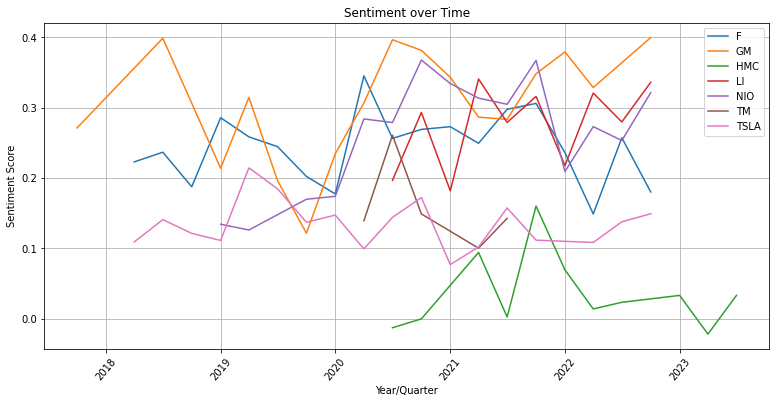

In [14]:
company_view_plots = sentiment_time_series(df = speaker_df, group_by = ["ticker"], same_plot = True, grid = True, plot_category_group = "ticker")

Function to add a vertical line (to mark a government/regulatory event) on all plots. Give an x value and a label

In [15]:
def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end

def add_vline_all_plots(plots, x, label, linestyle = "--", color = "b"):
    for i, plot in enumerate(plots):
        x_tick_labels = plot[1].get_xticklabels()
        x_values = [pd.to_datetime(label.get_text()) for label in x_tick_labels]
        if time_in_range(min(x_values), max(x_values), x):
            plot[1].axvline(x = x, color = color, linestyle = linestyle, label = label)
        plot[1].legend()

## 3. Government data

Here is a mapping of the governmental/regulatory events to its fiscal quarter:

In [16]:
events = {
    "Infrastructure Investment and Jobs Act": "2021Q4",
    "Electric CARS Act of 2021": "2021Q1",
    "Inflation Reduction Act of 2022": "2022Q3"
}

In [17]:
def add_events(plots, events):
    for i, (event, date) in enumerate(events.items()):
        color = list(mcolors.TABLEAU_COLORS.values())[i]
        add_vline_all_plots(plots, pd.to_datetime(date), event, color = color)

#### Individual company view

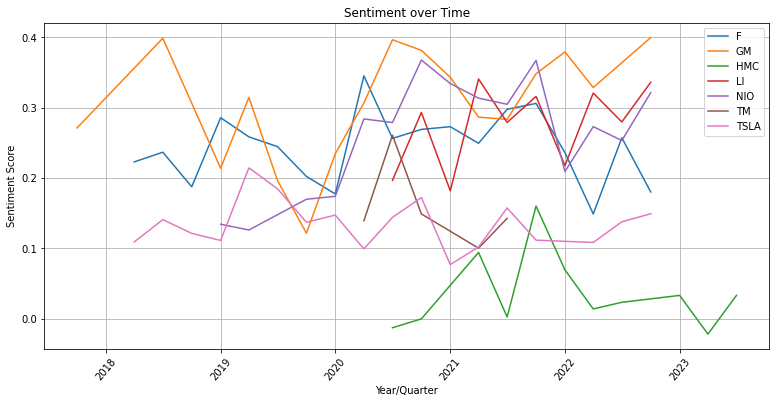

In [63]:
company_view_plots = sentiment_time_series(df = speaker_df, group_by = ["ticker"], same_plot = True, grid = True, plot_category_group = "ticker")


In [64]:
add_events(company_view_plots, events)

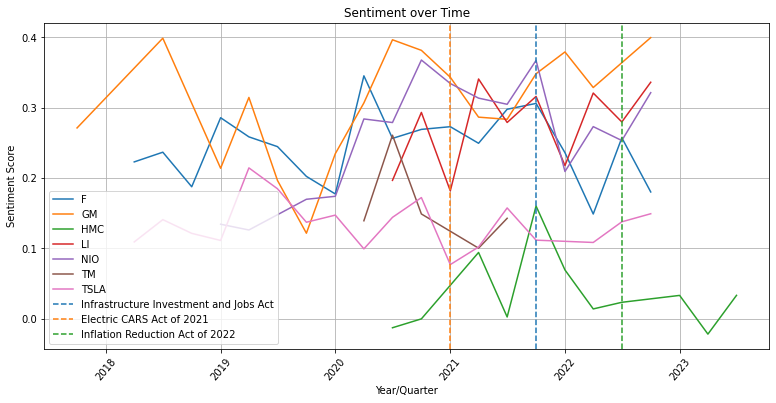

In [65]:
company_view_plots[0][0]

In [66]:
for plot in company_view_plots:
    plot[0].savefig(plot[1].get_title() + ".png")

#### Market view
- We must select only a subset of the market that will provide the best data representation. Note that after 2022Q4 the sentiment appears to drop significantly, but this is because we only have data for HMC after this point, which has lower sentiment than the other companies.
    - This is why this is a bad plot

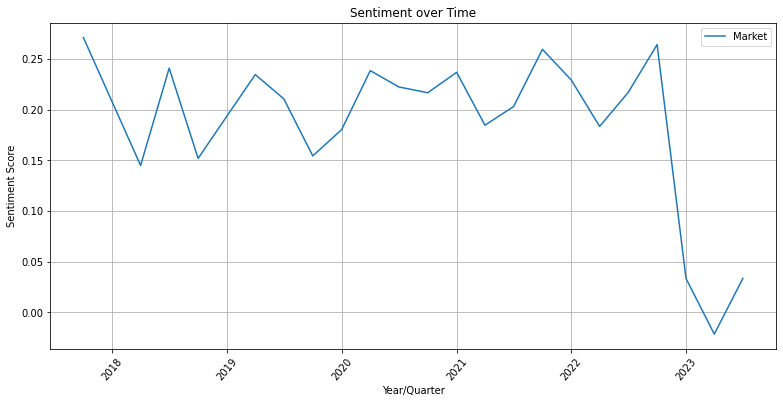

In [83]:
market_view_plots = sentiment_time_series(df = speaker_df, group_by = ["year-quarter"], same_plot = True, grid = True, plot_category_group = None)

In [84]:
add_events(market_view_plots, events)

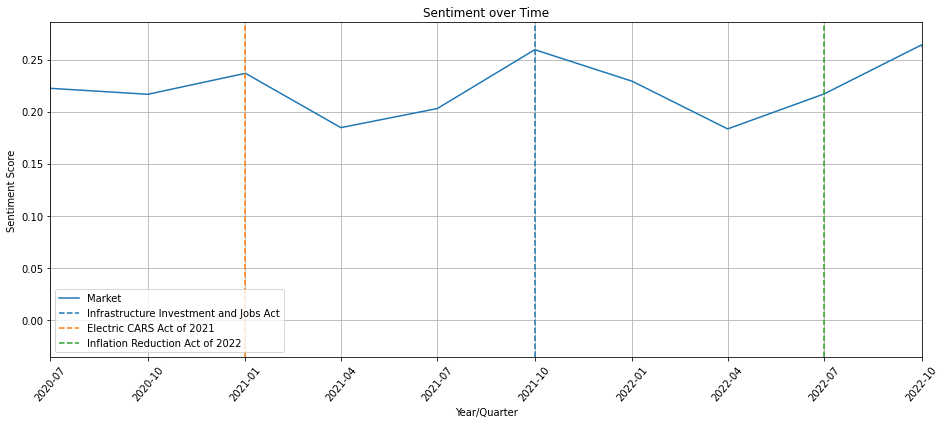

In [87]:
market_view_plots[0][0].tight_layout()
market_view_plots[0][1].set_xlim([pd.to_datetime("2020Q3"), pd.to_datetime("2022Q4")])
market_view_plots[0][0]

## Word clouds

In [132]:
from wordcloud import WordCloud

In [226]:
selected = speaker_df[speaker_df["ticker"] == "TSLA"]
df = selected[selected["year-quarter"] == "2021Q2"]

In [227]:
text = " ".join(df["sentence"])

In [228]:
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)

(-0.5, 399.5, 199.5, -0.5)

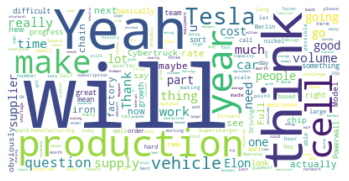

In [229]:
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")